# Image Classification with Masterful

In the [Quickstart](tutorial_quickstart.ipynb) guide, you looked at a simple classification example to get you up and running with the Masterful AutoML platform. In this guide, you will take a deeper look at Image Classification with Masterful, using a different model and dataset, and show some ways to analyze the results returned by the Masterful AutoML Platform.

This guide is based on the Tensorflow [Image Classification](https://www.tensorflow.org/tutorials/images/classification) tutorial, so that you can compare side-by-side with a non-Masterful training workflow. You use the same model and dataset as that tutorial.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/masterfulai/masterful-docs/blob/main/notebooks/guide_classification.ipynb)
[![download button](https://www.tensorflow.org/images/download_logo_32px.png)](https://masterful-public.s3.us-west-1.amazonaws.com/933013963/latest/guide_classification.ipynb) Download this Notebook

This guide requires Tensorflow 2.6+, as it uses some Keras data loading utilities that were added in 2.6.

## Import the Required Libraries

This guide uses [Tensorflow](https://www.tensorflow.org) for training and [Tensorflow Datasets](https://www.tensorflow.org/datasets) for the training data.

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds

## Register Masterful

The first step to using Masterful is to register the Masterful package using the account ID and authorization key provided to you. Registration is necessary to ensure you have a valid authorization key and are licensed to use the Masterful AutoML platform. Make sure to fill in the `<INSERT HERE>` sections with the account ID and authorization key provided to you by Masterful AI.

In [11]:
MASTERFUL_ACCOUNT_ID="<INSERT HERE>"
MASTERFUL_AUTHORIZATION_KEY="<INSERT HERE>"

# Note the registration call returns the registered masterful
# package. Make sure you update the reference to `masterful`
# like the below call, otherwise you will still be using the
# unregistered package, which has no training functionality.
import masterful
masterful = masterful.register(account_id=MASTERFUL_ACCOUNT_ID, 
                               authorization_key=MASTERFUL_AUTHORIZATION_KEY)

## Load the Data

You are using the dataset specified in the Tensorflow [Image Classification](https://www.tensorflow.org/tutorials/images/classification) tutorial. According to that tutorial, the dataset consists of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [12]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

You can verify that the data was downloaded correctly by displaying
a few examples from the dataset, to make sure the data is formatted and labeled as expected.

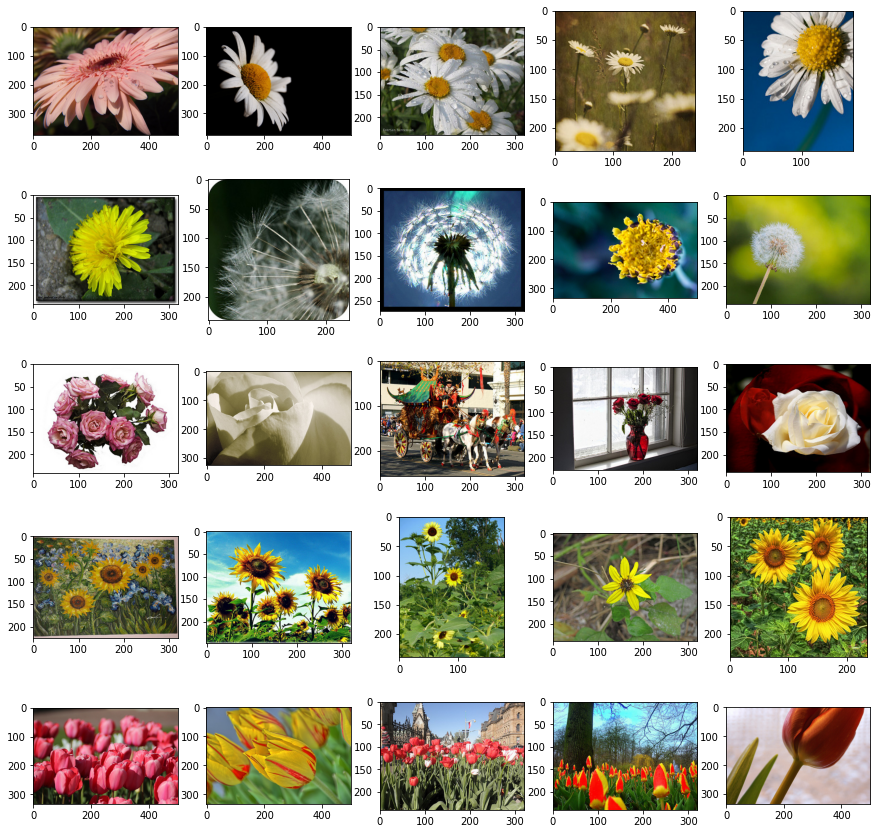

In [13]:
import matplotlib.pyplot as plt
import PIL

daisy = list(data_dir.glob('daisy/*'))[0:5]
dandelion = list(data_dir.glob('dandelion/*'))[0:5]
roses  = list(data_dir.glob('roses/*'))[0:5]
sunflowers  = list(data_dir.glob('sunflowers/*'))[0:5]
tulips = list(data_dir.glob('tulips/*'))[0:5]

images = [daisy, dandelion, roses, sunflowers, tulips]
COLUMNS=5
ROWS=len(images)

f, axarr = plt.subplots(5, 5, figsize=(15,15))
curr_row = 0

for row, image_row in enumerate(images):
  for col, image_col in enumerate(image_row):
    image = PIL.Image.open(image_col)
    axarr[row, col].imshow(image)

Let's load these images off disk using the helpful [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) in just a couple lines of code.

In [14]:
NUM_CLASSES = 5
INPUT_SHAPE=(180,180,3)

# Load all of the images into a tf.data.Dataset. Why do you not create a train
# and validation
# split here, similar to the Tensorflow tutorial? This is because of a limitation with
# the image_dataset_from_directory function and the way it handles shuffling. The ideal
# training regime consists of:
# 
# - a training set, which is used for back propagation against your model
# - a validation set, to measure the performance of your training
# - a test (holdout) set, to measure the performance of your *trained* model
#
# It is vitally important that your test data is never seen by your training loop. And equally
# important, your training and validation sets must never co-mingle. Keras 
# image_dataset_from_directory() can only create 2 splits, so you can either have a train/val split
# or a train/test split. Due to the way the Flowers dataset is constructed on disk, you need
# to use shuffle=True (the default) with a fixed seed when creating both splits, otherwise your splits
# will not contain examples from every class. This is the code you see in the Image classification
# tutorial. That tutorial only uses a train/val split because it trains for a fixed number of epochs,
# and it requires you to use the results from the last epoch, otherwise you have implicitly overfit
# your data to your holdout set, which will hurt your generalization performance at inference time
# when you see novel examples. So how can you get a train/val/test split from image_dataset_from_directory?
# The naive approach would be to create a train and test split, and then split the test dataset
# into a validation and holdout dataset (or equivalently, split the train set into a train/val set).
# This will not work however, because image_dataset_from_directory includes a shuffle operation, which
# reshuffles the data at each iteration through the dataset. So naively splitting one of the returned
# datasets will actually mix these datasets together at each epoch, introducing dataset co-mingling
# inadvertently.
#
# So how do you get a train/test/val split? You use image_dataset_from_directory() WITHOUT shuffling,
# to grab all of the data. Since this dataset is deterministic, You can then manually split this dataset
# into train and test (holdout). Masterful will automatically create a validation split from the training
# data, so you don't need to worry about that part, and Masterful will never see the test dataset,
# so there is no risk of overfitting to your test/holdout data.
dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
  shuffle=False,
  label_mode='categorical',
)

# Masterful works with unbatched datasets. Unfortunately image_dataset_from_directory
# only provides batched data, so you need to manually unbatch it here.
dataset = dataset.unbatch()

# Split the data into a labeled set for training and a test dataset for evaluation.
# Note the test_dataset will never be seen by Masterful. In this way, you can
# ensure that your training will never overfit to your holdout dataset.
# You use an internal utility of Masterful for convenience here, but any method
# of splitting the dataset, such as filtering (https://www.tensorflow.org/api_docs/python/tf/data/Dataset#filter),
# works equally well.
labeled_dataset, test_dataset = masterful.utils.dataset.split_dataset(
  dataset, 0.2)

Found 3670 files belonging to 5 classes.


## Build the Model

You can use the same model as the Tensorflow [Image Classification](https://www.tensorflow.org/tutorials/images/classification) tutorial, so that you can compare the results to that guide. Note that the model is outputting logits rather than a softmax activation, which will be important for Masterful in the next steps.

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=INPUT_SHAPE),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_42 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train with Masterful

The first step when using Masterful is to specify some design choices about your model by using `masterful.spec.create_model_and_data_specs`. Masterful tries to infer as much as possible about your model and dataset, but for things which cannot be inferred, Masterful has created `masterful.ModelSpec` and `masterful.DataSpec` data structures to inform the platform about these choices. 

In the example below, you are letting Masterful know that you are performing a classification task (`masterful.spec.Task.CLASSIFICATION`) with 5 labels (`num_classes=NUM_CLASSES`), and that your input image features are in the range [0,255] (`image_range=masterful.spec.ImageRange.ZERO_255`). Furthermore, you are providing dense labels (`sparse=False`) and that your model is outputting logits rather than a softmax classification (`from_logits=True`). 

In [16]:
model_spec, data_spec = masterful.spec.create_model_and_data_specs(
    model=model, 
    dataset=labeled_dataset, 
    task=masterful.spec.Task.CLASSIFICATION, 
    image_range=masterful.spec.ImageRange.ZERO_255, 
    num_classes=NUM_CLASSES, 
    sparse=False, 
    from_logits=True,
)

Now, you are ready to train your model using the Masterful AutoML platform. In the next cell, you will see the call to `masterful.autofit`, which is the entry point to the meta-learning engine of the Masterful AutoML platform. Notice there is no need to batch your data (Masterful will find the optimal batch size for you). No need to shuffle your data (Masterful handles this for you). You don't even need to pass in a validation dataset (Masterful finds one for you). You hand Masterful a model and a dataset, and Masterful will figure the rest out for you.

In [17]:
fit_policy, fit_report = masterful.autofit(
  model, 
  model_spec, 
  labeled_dataset, 
  data_spec,
)

MASTERFUL: Auto-fitting model to datasets.
MASTERFUL: Performing basic dataset analysis.
MASTERFUL: Training model with:
MASTERFUL: 	2936 labeled examples.
MASTERFUL: 	0 validation examples.
MASTERFUL: 	0 synthetic examples.
MASTERFUL: 	0 unlabeled examples.
MASTERFUL: Masterful will use 293 labeled examples as a validation set since no validation data was provided.


...
MASTERFUL: Unsupervised training complete.
MASTERFUL: Training complete in 23.23731665611267 minutes.


## Analyze the Results

Now that the model is trained, its important to understand how the model will perform when introduced to data it has never seen before. This is why we created holdout set (`test_dataset`) earlier. Your model has never seen this data during training, so it can be a good estimate for the generalization performance of the model.

In [18]:
fit_report.model.evaluate(
  test_dataset.batch(fit_policy.batch_size), 
  return_dict=True,
)

23/23 [==============================] - 1s 19ms/step - loss: 0.6831 - categorical_accuracy: 0.7316


{'loss': 0.6830766797065735, 'categorical_accuracy': 0.7316076159477234}

As you can see above, the model achieves `73.1%` accuracy on the test dataset. This is an excellent result, as the Tensorflow tutorial model only achieved `68.9%` accuracy, and that was after manually selecting and tuning augmentations and inserting dropout with an experimentally determined dropout rate. Masterful has handled all of these details for you, so that you can focus on solving your customer use cases, rather than getting bogged down in the details of model and the intricacies of training with best practices and state of the art research. 